In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import scipy.optimize as opt
import time

In [2]:
def sigmoid(Theta, X):
    z = Theta @ X
    return  1 / (1 + np.exp(-z))

In [3]:
def flatten(Matrix_arr):
    return np.hstack(tuple([M.ravel(order='F') for M in Matrix_arr]))

def deflatten(flatten, units):
    Thetas = []
    t = 0
    for u in range(len(units) - 1):
        Theta = flatten[t: t + units[u + 1] * (units[u] + 1)]
        Theta = np.reshape(Theta, (units[u + 1], units[u] + 1), 'F')
        t = t + units[u + 1] * (units[u] + 1)
        Thetas.append(Theta)
    return Thetas

# def deflatten(flatten, units):
#     Theta1 = np.reshape(flatten[:30 * 401], (30, 401), 'F')
#     Theta2 = np.reshape(flatten[30 * 401: 30 * 401 + 31 * 31], (31, 31), 'F')
#     Theta3 = np.reshape(flatten[30 * 401 + 31 * 31:],  (10, 31), 'F')
#     return [Theta1, Theta2, Theta3]

In [4]:
def forward_propagation(Thetas, X, L):
    activations = []
    # input params are activations for inpul layer
    activations.append(X)
    for l in range(L - 1):
        # adding bias unit
        activations[l] = np.concatenate((np.ones((1, activations[l].shape[1])), activations[l]), axis=0)
        h = sigmoid(Thetas[l], activations[l])
        activations.append(h)
    return activations   

![Alt text](static/img/nn_diagram.png)

![Alt text](static/img/backpropagation.png)

In [5]:
def back_propagation(flatten_theta, units, X, y, L, lmbda):
    Thetas = deflatten(flatten_theta, units)
    a = forward_propagation(Thetas, X, L) # [(401, 5000), (26, 5000), (10, 5000)]
    m = X.shape[1]
    
    δ = [0 for x in range(L - 1)]
    Δ = [0 for x in range(L - 1)]
    D = [0 for x in range(L - 1)]
    
    δ[-1] = a[-1] - y
    for l in (range(L - 2, 0, -1)):
        δ[l-1] = Thetas[l].T @ δ[l] * (a[l] * (1 - a[l]))

        
    Δ[-1] = δ[-1] @ a[-2].T
    for l in (range(0, L - 2)):
        Δ[l] = δ[l][1:] @ a[l].T
        
    for i in range(len(Δ)):
        grad = (1 / m) * Δ[i]
        grad[:, 1:] = grad[:, 1:] + Thetas[i][:, 1:] * (lmbda / m)
        D[i] = grad
    return  flatten(D)

### Cost Function with regularization

![Alt text](static/img/nn_cost_func.png)

In [6]:
def cost_fn(flatten_theta, units ,X, Y, L, lmbda):
    Thetas = deflatten(flatten_theta, units)
    Y_predicted = forward_propagation(Thetas, X, L)[-1]
    m = Y.shape[1]
    K = Y.shape[0]
    error = 0
    for k in range(K):
        y_equel_1 =  np.log(Y_predicted[k]) @ Y[[k]].T
        y_equel_0 = np.log(1 - Y_predicted[k]) @  (1 - Y[[k]]).T
        error += (y_equel_1 + y_equel_0)
    regularization = lmbda / (2 * m) * sum([np.power(Theta[:, 1:], 2).sum() for Theta in Thetas])
    cost  = -(1 / m) * error + regularization
    return cost

In [21]:
class NeuralNetwork():
    def __init__(self):
        self.L = 0
        self.units = []
    
    def AddLayer(self, units):
        self.L += 1
        self.units.append(units)
        print(f"Added {self.L} layer with {units} units")
        
    def fit(self, X, y, Thetas=None, lmbda=1, maxiter=50):
        if Thetas is None:
            Thetas = self._generate_random_parameters()
        
        flatten_theta = flatten(Thetas)
        theta_opt = opt.fmin_cg(maxiter = maxiter, 
                    f = cost_fn, 
                    x0 = flatten_theta, 
                    fprime = back_propagation,
                    args = (self.units, X, y, self.L, lmbda))
        return deflatten(theta_opt, self.units)
            
    def predict(self, X, y, lmbda):
         raise NotImplementedError

    def _generate_random_parameters(self):
        epsilon_init = 0.12
        Thetas = []
        for s in range(len(self.units) - 1):
            Theta = np.random.random((self.units[s + 1], self.units[s] + 1))
            Theta = Theta * 2 * epsilon_init
            Theta = Theta - epsilon_init
            Thetas.append(Theta)
        return Thetas
    

## Recognition hand-written digits 

In [8]:
raw_training_set = sio.loadmat('static/datasets/handwritten-numbers/ex3data1.mat')
raw_theta = sio.loadmat('static/datasets/handwritten-numbers/ex3weights.mat')

In [9]:
data = np.concatenate((raw_training_set['X'], raw_training_set['y']), axis=1)
# np.random.shuffle(data)
X = data[:, :-1]
X = X.T
y = data[:, [-1]]
# y = np.where(y == 10, 0, y)
y = range(1, 11) == y; # because class 10 is 0
y = y.astype(int)
y = y.T

In [10]:
Theta1 = np.array(raw_theta['Theta1']) # (25, 401)
Theta2 = np.array(raw_theta['Theta2']) # (10, 26)

In [23]:
model = NeuralNetwork()

model.AddLayer(units=400) # input layer
model.AddLayer(units=30)  # hidden layer
# model.AddLayer(units=30)  # hidden layer
model.AddLayer(units=10)  # output layer 
    
Theta1 = np.random.random((30, 401))
Theta2 = np.random.random((31, 31))
Theta3 = np.random.random((31, 10))
Thetas = model.fit(X, y)

# model.predict(X)

Added 1 layer with 400 units
Added 2 layer with 30 units
Added 3 layer with 10 units
         Current function value: 0.430155
         Iterations: 50
         Function evaluations: 109
         Gradient evaluations: 109


In [12]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        # Display Image
        h = ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                      cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

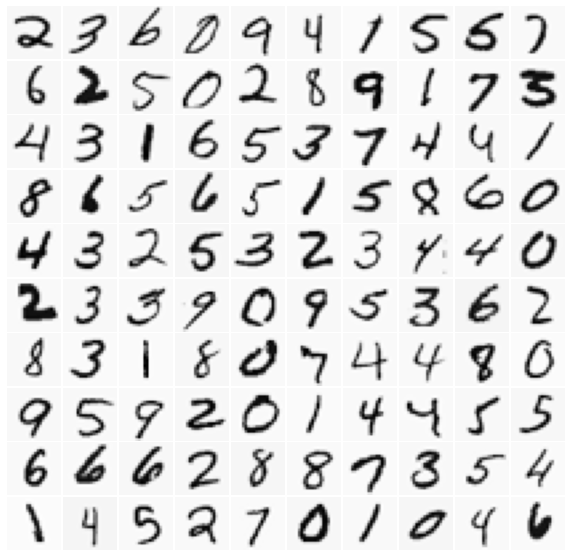

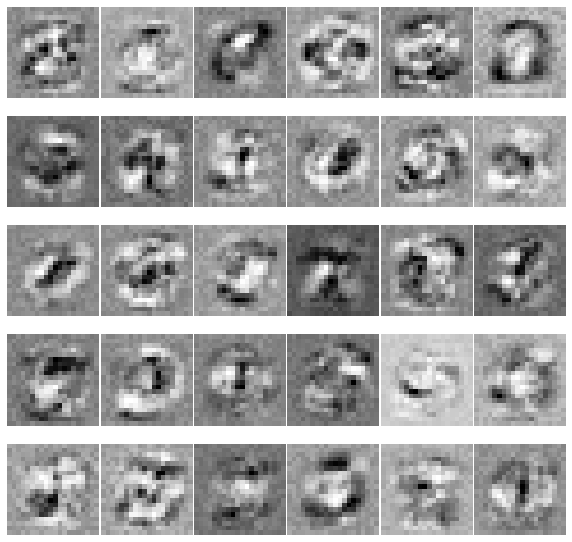

In [35]:
rand_indices = np.random.choice(5000, 100, replace=False)
activation = forward_propagation(Thetas, X, 3)
displayData(activation[0][1:, rand_indices].T)
displayData(Thetas[0][:, 1:])

In [ ]:
np.mean(np.argmax(output, axis=0) + 1 == data[:, -1]) * 100